# ABS Tutorial 07 (for template fitting)

## template fitting mock data test (simple likelihood, T maps)

The `simple likelihood` is designed for pipeline's sanity check:

$$ \mathcal{L} =  - 0.5 \left( X^T \mathcal{M}^{-1}_{cc'} X \right) $$

where X is the vectorized cross-power-spectrum which contains band-power from each `frequency` and `multipole bin`, the covariance matrix is approximated by noise re-sampling.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import abspy as ap
from abspy.methods.tpfit import tpfit_simple
import seaborn as sns
from dynesty import plotting as dyplot
from abspy.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from abspy.tools.bg_models import cmbmodel
from abspy.tools.aux import vec_simple
import warnings
warnings.filterwarnings('ignore')

### read maps

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


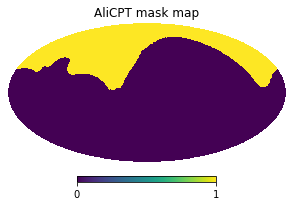

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30 = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95 = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150 = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353 = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353+mapcmb,fwhm=fwhm[3])

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

fig = plt.figure(figsize=(5,5))
gs = gsp.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

### 1st run with sync model

- mock data frequencies: 30, 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -2.5}
cmb truths:  {'bp_c_T_41.5': 1289.4460584504413, 'bp_c_T_121.5': 3113.015521606617, 'bp_c_T_201.5': 5251.288856834484}
CPU times: user 10min 54s, sys: 4.46 s, total: 10min 59s
Wall time: 2min 59s


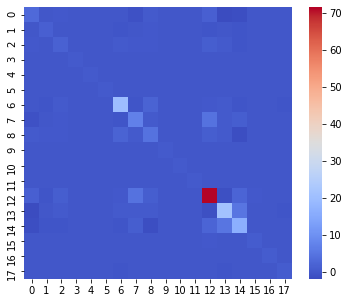

In [3]:
%%time

FREQS = [30.,95.,150.]
NMAP = 1
RESAMP = 60
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[30] = vmap30[0].reshape(1,-1)
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[30] = fwhm[0]
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = ap.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30[0].reshape(1,-1)

tmpmap_fwhms = dict()
tmpmap_fwhms[30] = fwhm[0]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=tmpmap_fwhms)

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(b.params)):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(s.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
4
parameters
dict_keys(['bp_c_T_41.5', 'bp_c_T_121.5', 'bp_c_T_201.5', 'beta_s'])
parameter range
{'bp_c_T_41.5': [0.0, 10000.0], 'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_s': [-5.0, 0.0]}




iter: 32520 | +1000 | bound: 57 | nc: 1 | ncall: 119979 | eff(%): 27.938 | loglstar:   -inf < -0.021 <    inf | logz: -32.543 +/-  0.264 | dlogz:  0.001 >  1.009                                     

CPU times: user 5min 50s, sys: 9min 58s, total: 15min 48s
Wall time: 5min 49s


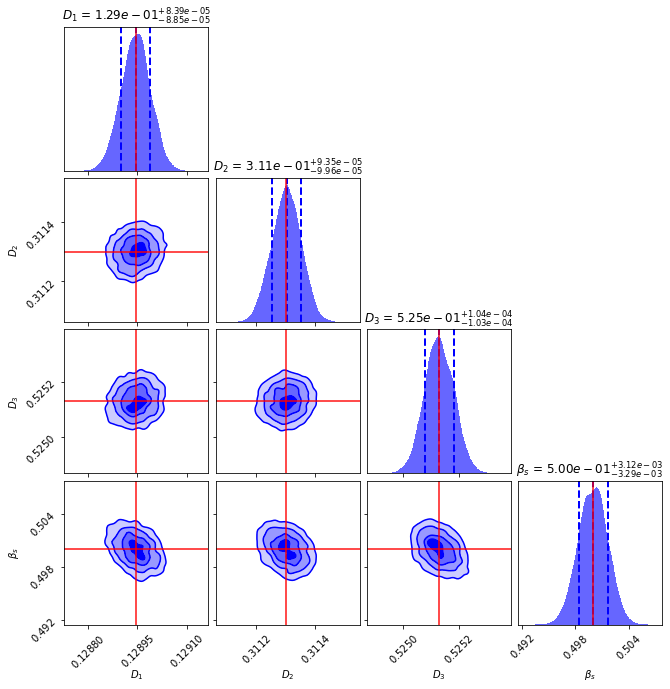

In [4]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,s)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1]/1.e+4) + [0.5]
labels = [r'$D_1$',r'$D_2$',r'$D_3$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 2nd run with dust model

- mock data frequencies: 95, 150, 353
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 2.5}
cmb truths:  {'bp_c_T_41.5': 1289.4460584504413, 'bp_c_T_121.5': 3113.015521606617, 'bp_c_T_201.5': 5251.288856834484}
CPU times: user 10min 23s, sys: 3.04 s, total: 10min 26s
Wall time: 2min 38s


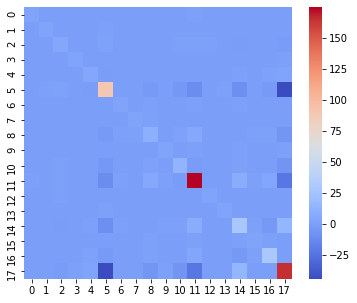

In [5]:
%%time

FREQS = [95.,150.,353.]
NMAP = 1
RESAMP = 60
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[353] = map353[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[353] = vmap353[0].reshape(1,-1)
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[353] = fwhm[3]
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = ap.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353[0].reshape(1,-1)

tmpmap_fwhms = dict()
tmpmap_fwhms[353] = fwhm[-1]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=tmpmap_fwhms)

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(b.params)):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(d.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
4
parameters
dict_keys(['bp_c_T_41.5', 'bp_c_T_121.5', 'bp_c_T_201.5', 'beta_d'])
parameter range
{'bp_c_T_41.5': [0.0, 10000.0], 'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_d': [0.0, 5.0]}




iter: 33428 | +1000 | bound: 49 | nc: 1 | ncall: 107913 | eff(%): 31.903 | loglstar:   -inf < -0.093 <    inf | logz: -33.503 +/-  0.267 | dlogz:  0.001 >  1.009                                     

CPU times: user 6min 8s, sys: 10min 28s, total: 16min 36s
Wall time: 6min 2s


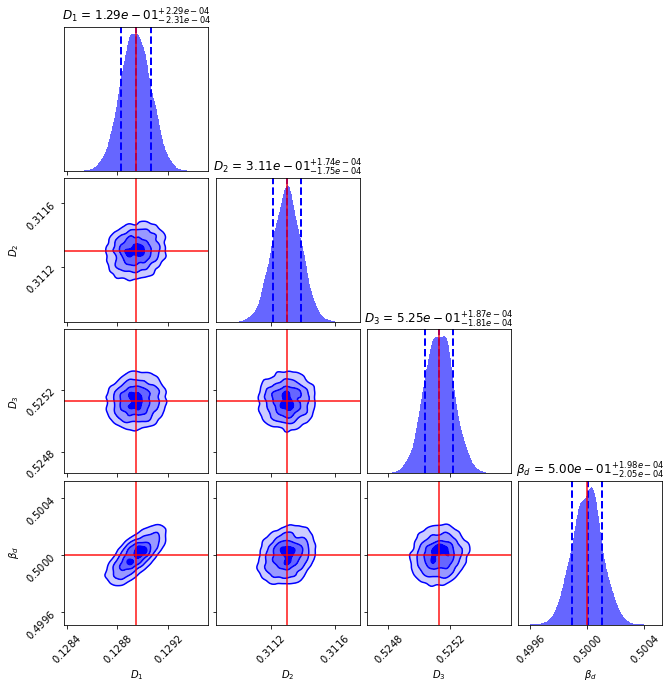

In [6]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,d)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1]/1.e+4) + [0.5]
labels = [r'$D_1$',r'$D_2$',r'$D_3$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 3rd run with sync+dust model

- mock data frequencies: 30, 95, 150, 353
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -2.5, 'beta_d': 2.5, 'rho': 0.0}
cmb truths:  {'bp_c_T_41.5': 1289.4460584504413, 'bp_c_T_121.5': 3113.015521606617, 'bp_c_T_201.5': 5251.288856834484}
CPU times: user 18min 29s, sys: 820 ms, total: 18min 30s
Wall time: 4min 59s


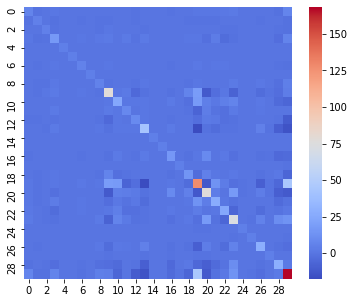

In [7]:
%%time

FREQS = [30.,95.,150.,353.]
NMAP = 1
RESAMP = 60
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[353] = map353[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[30] = vmap30[0].reshape(1,-1)
fullvar[353] = vmap353[0].reshape(1,-1)
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[30] = fwhm[0]
fullbeam[353] = fwhm[3]
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = ap.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30[0].reshape(1,-1)
tmpmap[353] = map353[0].reshape(1,-1)

tmpmap_fwhms = dict()
tmpmap_fwhms[30] = fwhm[0]
tmpmap_fwhms[353] = fwhm[-1]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
                  templates=tmpmap,template_fwhms=tmpmap_fwhms)

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(b.params)):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(c.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
6
parameters
dict_keys(['bp_c_T_41.5', 'bp_c_T_121.5', 'bp_c_T_201.5', 'beta_s', 'beta_d', 'rho'])
parameter range
{'bp_c_T_41.5': [0.0, 10000.0], 'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}




iter: 45555 | +1000 | bound: 99 | nc: 1 | ncall: 184420 | eff(%): 25.244 | loglstar:   -inf < -0.219 <    inf | logz: -45.898 +/-  0.316 | dlogz:  0.001 >  1.009                                     

CPU times: user 20min 45s, sys: 28min 39s, total: 49min 24s
Wall time: 15min 33s


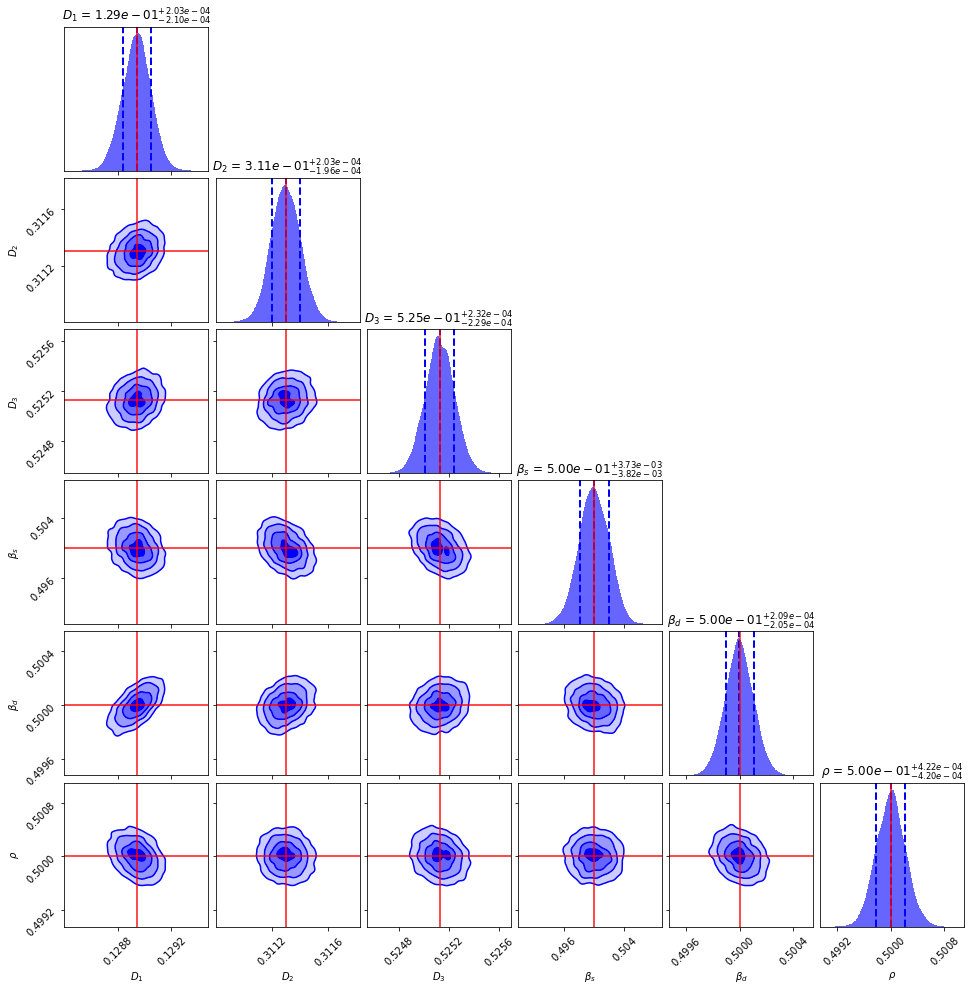

In [8]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,c)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1]/1.e+4) + [0.5,0.5,0.5]
labels = [r'$D_1$',r'$D_2$',r'$D_3$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

end